In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score

# Загрузка

In [2]:
df_train = pd.read_csv('application_data.csv')

In [3]:
# сократим до 100.000
df_train = df_train.sample(100_000)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 193220 to 203783
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 93.8+ MB


In [5]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
193220,324065,1,Cash loans,F,Y,Y,1,135000.0,263686.5,26208.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
32111,137235,0,Cash loans,F,N,Y,0,270000.0,746280.0,59094.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
25104,129201,0,Cash loans,F,N,Y,0,279000.0,536917.5,30109.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
186096,315742,0,Revolving loans,F,N,Y,3,112500.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
211059,344590,0,Cash loans,F,N,Y,0,144000.0,1506816.0,47313.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


# Предобработка

In [6]:
# удалим колонки, где пропусков больше 50 %
df_train_isna_percentage = round(df_train.isnull().sum()*100/len(df_train.index),1)
df_train_isna_percentage = df_train_isna_percentage[df_train_isna_percentage.values > 50.0]
df_train = df_train.drop(columns = df_train_isna_percentage.index)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 193220 to 203783
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    100000 non-null  int64  
 1   TARGET                        100000 non-null  int64  
 2   NAME_CONTRACT_TYPE            100000 non-null  object 
 3   CODE_GENDER                   100000 non-null  object 
 4   FLAG_OWN_CAR                  100000 non-null  object 
 5   FLAG_OWN_REALTY               100000 non-null  object 
 6   CNT_CHILDREN                  100000 non-null  int64  
 7   AMT_INCOME_TOTAL              100000 non-null  float64
 8   AMT_CREDIT                    100000 non-null  float64
 9   AMT_ANNUITY                   99994 non-null   float64
 10  AMT_GOODS_PRICE               99922 non-null   float64
 11  NAME_TYPE_SUITE               99574 non-null   object 
 12  NAME_INCOME_TYPE              100000 no

In [7]:
# Заполним пропуски медианными значениями
median_columns = list(df_train.isna().sum().index)
df_train[median_columns] = df_train[median_columns].fillna(df_train[median_columns].median())
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 193220 to 203783
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    100000 non-null  int64  
 1   TARGET                        100000 non-null  int64  
 2   NAME_CONTRACT_TYPE            100000 non-null  object 
 3   CODE_GENDER                   100000 non-null  object 
 4   FLAG_OWN_CAR                  100000 non-null  object 
 5   FLAG_OWN_REALTY               100000 non-null  object 
 6   CNT_CHILDREN                  100000 non-null  int64  
 7   AMT_INCOME_TOTAL              100000 non-null  float64
 8   AMT_CREDIT                    100000 non-null  float64
 9   AMT_ANNUITY                   100000 non-null  float64
 10  AMT_GOODS_PRICE               100000 non-null  float64
 11  NAME_TYPE_SUITE               99574 non-null   object 
 12  NAME_INCOME_TYPE              100000 no

<ipython-input-7-ba3f60a38c69>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_train[median_columns] = df_train[median_columns].fillna(df_train[median_columns].median())


In [8]:
# заменим пустые значение в категориальных признаках на моду

object_columns = list(df_train.select_dtypes(include=['object']).columns)

df_object_columns = df_train.loc[:,object_columns]
d = df_object_columns.isna().sum() 
list(d[d.values != 0].index)

['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE']

In [9]:
df_train['NAME_TYPE_SUITE'] = df_train['NAME_TYPE_SUITE'].fillna(df_train['NAME_TYPE_SUITE'].mode()[0])
df_train['OCCUPATION_TYPE'] = df_train['OCCUPATION_TYPE'].fillna(df_train['OCCUPATION_TYPE'].mode()[0])
df_train['EMERGENCYSTATE_MODE'] = df_train['EMERGENCYSTATE_MODE'].fillna(df_train['EMERGENCYSTATE_MODE'].mode()[0])

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 193220 to 203783
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    100000 non-null  int64  
 1   TARGET                        100000 non-null  int64  
 2   NAME_CONTRACT_TYPE            100000 non-null  object 
 3   CODE_GENDER                   100000 non-null  object 
 4   FLAG_OWN_CAR                  100000 non-null  object 
 5   FLAG_OWN_REALTY               100000 non-null  object 
 6   CNT_CHILDREN                  100000 non-null  int64  
 7   AMT_INCOME_TOTAL              100000 non-null  float64
 8   AMT_CREDIT                    100000 non-null  float64
 9   AMT_ANNUITY                   100000 non-null  float64
 10  AMT_GOODS_PRICE               100000 non-null  float64
 11  NAME_TYPE_SUITE               100000 non-null  object 
 12  NAME_INCOME_TYPE              100000 no

In [11]:
# Кодирование категориальных признаков типа OneHotEncoder

df_train = pd.get_dummies(df_train, drop_first=True)
df_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_Yes
193220,324065,1,1,135000.0,263686.5,26208.0,238500.0,0.018029,-9539,-639,...,0,0,0,0,0,0,0,0,0,0
32111,137235,0,0,270000.0,746280.0,59094.0,675000.0,0.007020,-11607,-1482,...,0,0,0,0,0,0,0,0,0,0
25104,129201,0,0,279000.0,536917.5,30109.5,463500.0,0.072508,-10972,-704,...,0,0,0,0,0,0,0,0,0,0
186096,315742,0,3,112500.0,180000.0,9000.0,180000.0,0.035792,-13741,-1172,...,0,0,0,0,0,0,0,0,0,0
211059,344590,0,0,144000.0,1506816.0,47313.0,1350000.0,0.007120,-21035,365243,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# разбивка

X = df_train.drop(columns = ['TARGET'])
y = df_train['TARGET']

X_train, X_valid, y_train, y_valid= train_test_split(X, y, test_size=0.20, random_state=111222, stratify=y)

X_train.shape, X_valid.shape

((80000, 178), (20000, 178))

In [13]:
# удаление неважных

importances = mutual_info_classif(X_train, y_train)
feature_importances = pd.Series(importances, X_train.columns[0:len(X_train.columns)])

important_feature = feature_importances[feature_importances.values > 0.01]
drop_feature = feature_importances[feature_importances.values <= 0.01]

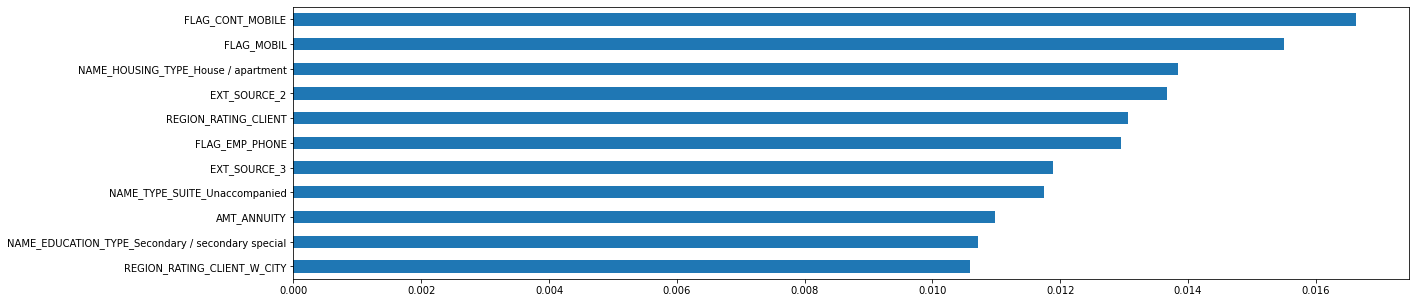

In [14]:
# посмотрим на важные

plt.figure(figsize=(20,5))
important_feature.sort_values().plot(kind='barh')
plt.show()

In [15]:
len(X_train.columns), len(drop_feature.index)

(178, 167)

In [16]:
X_train = X_train.drop(columns = drop_feature.index)
X_valid = X_valid.drop(columns = drop_feature.index)
len(X_train.columns)

11

In [17]:
# отмасштабируем

numeric = list(X_train.columns)

scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_train.sample(10)

,AMT_ANNUITY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2,EXT_SOURCE_3,NAME_TYPE_SUITE_Unaccompanied,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_HOUSING_TYPE_House / apartment
169257,-0.375340,0.003536,0.468105,0.046956,-0.102547,-0.062065,0.452622,0.639698,0.482512,-1.568123,0.354405
271734,0.921563,0.003536,0.468105,0.046956,-0.102547,-0.062065,0.924457,-0.013867,0.482512,-1.568123,0.354405
48298,-0.187455,0.003536,-2.136275,0.046956,1.855391,1.920050,-1.560043,1.026930,0.482512,0.637705,0.354405
161508,-0.953567,0.003536,0.468105,0.046956,-0.102547,-0.062065,-1.487598,0.413693,0.482512,0.637705,0.354405
298009,0.247533,0.003536,0.468105,0.046956,-0.102547,-0.062065,-1.018776,-2.194638,0.482512,0.637705,0.354405
30037,1.306325,0.003536,0.468105,0.046956,-0.102547,-0.062065,0.236839,0.119713,0.482512,0.637705,0.354405
1892,-0.029024,0.003536,0.468105,0.046956,-0.102547,-0.062065,-1.052756,-1.439918,0.482512,0.637705,0.354405
249007,-0.861485,0.003536,-2.136275,0.046956,-0.102547,-0.062065,-0.369338,1.229571,0.482512,0.637705,0.354405
154975,-0.170403,0.003536,0.468105,0.046956,-0.102547,-0.062065,1.291709,1.293734,0.482512,0.637705,0.354405
287133,0.406275,0.003536,0.468105,0.046956,1.855391,1.920050,-1.828534,-1.350595,0.482512,0.637705,-2.821627


# Уменьшение размерности

In [18]:
X_train_embedded = TSNE(n_components=2, learning_rate = 'auto', n_jobs = -1).fit_transform(X_train[:10000])
X_train_embedded.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(10000, 2)

In [19]:
X_train_embedded[:, 0].shape, X_train_embedded[:, 1].shape, y_train[:10000].shape

((10000,), (10000,), (10000,))

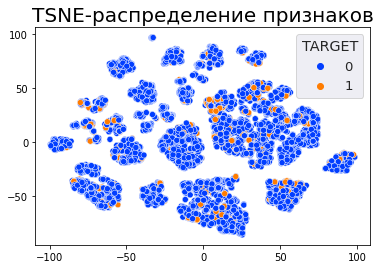

In [20]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = X_train_embedded[:, 0], y = X_train_embedded[:, 1], hue=y_train[:10000], palette='bright')
ax.set_title('TSNE-распределение признаков', fontsize=20)
plt.show()

# Обучение моделей

## Логистическая регрессия

In [21]:
random_state = 1

In [22]:
params = dict(
    C = [100, 10, 1, 0.1, 0.01, 0.001],
    penalty=['l1', 'l2', 'elasticnet'],
    solver=['saga'],
    multi_class =['auto', 'ovr', 'multinomial'],
    l1_ratio=[1]
)

In [23]:
lr = LogisticRegression()
lr = RandomizedSearchCV(lr, params, n_jobs=-1, cv=5, random_state=random_state)
lr.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01, 0.001],
                                        'l1_ratio': [1],
                                        'multi_class': ['auto', 'ovr',
                                                        'multinomial'],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['saga']},
                   random_state=1)

In [24]:
best_params = lr.best_params_
best_params

{'solver': 'saga',
 'penalty': 'elasticnet',
 'multi_class': 'auto',
 'l1_ratio': 1,
 'C': 0.001}

In [25]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = lr.predict(X)
  f1 = f1_score(y, lr.predict(X), average='micro').round(3)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1}')
  print(f'ROC_AUC {label}={roc_auc_score(y, lr.predict_proba(X)[:, 1]):.3f}\n')

Acc train=0.918
F1 train=0.918
ROC_AUC train=0.708

Acc test=0.918
F1 test=0.918
ROC_AUC test=0.716



In [26]:
print(classification_report(y_train, lr.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     73432
           1       0.00      0.00      0.00      6568

    accuracy                           0.92     80000
   macro avg       0.46      0.50      0.48     80000
weighted avg       0.84      0.92      0.88     80000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print(classification_report(y_valid, lr.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18358
           1       0.00      0.00      0.00      1642

    accuracy                           0.92     20000
   macro avg       0.46      0.50      0.48     20000
weighted avg       0.84      0.92      0.88     20000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Случайный лес

In [28]:
params = dict(
    n_estimators = range(5, 150, 5),
    min_samples_split = range(1, 20, 2),
    min_samples_leaf = range(1, 20, 2),
    max_samples = np.linspace(0, 1, 20)
)

In [29]:
rf = RandomForestClassifier()
rf = RandomizedSearchCV(rf, params, n_jobs=-1, cv=5, random_state=random_state)
rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_samples': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                                        'min_samples_leaf': range(1, 20, 2),
                                        'min_samples_split': range(1, 20, 2),
                                        'n_estimators': range(5, 150, 5)},
                   random_state=1)

In [30]:
best_params = rf.best_params_
best_params

{'n_estimators': 110,
 'min_samples_split': 19,
 'min_samples_leaf': 3,
 'max_samples': 0.21052631578947367}

In [31]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = rf.predict(X)
  f1 = f1_score(y, rf.predict(X), average='micro').round(3)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1}')
  print(f'ROC_AUC {label}={roc_auc_score(y, rf.predict_proba(X)[:, 1]):.3f}\n')

Acc train=0.918
F1 train=0.918
ROC_AUC train=0.849

Acc test=0.918
F1 test=0.918
ROC_AUC test=0.722



In [32]:
print(classification_report(y_train, rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     73432
           1       0.82      0.01      0.02      6568

    accuracy                           0.92     80000
   macro avg       0.87      0.50      0.49     80000
weighted avg       0.91      0.92      0.88     80000



In [33]:
print(classification_report(y_valid, rf.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18358
           1       0.58      0.00      0.01      1642

    accuracy                           0.92     20000
   macro avg       0.75      0.50      0.48     20000
weighted avg       0.89      0.92      0.88     20000



## Дерево решений

In [34]:
params = dict(
    max_depth = [3, None],
    max_features = range(1, 9, 1),
    min_samples_leaf = range(1, 9, 1),
    criterion = ["gini", "entropy"]
)

In [35]:
dt = DecisionTreeClassifier()
dt = RandomizedSearchCV(dt, params, n_jobs=-1, cv=5, random_state=random_state)
dt.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': range(1, 9),
                                        'min_samples_leaf': range(1, 9)},
                   random_state=1)

In [36]:
best_params = dt.best_params_
best_params

{'min_samples_leaf': 8,
 'max_features': 7,
 'max_depth': 3,
 'criterion': 'entropy'}

In [37]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = dt.predict(X)
  f1 = f1_score(y, dt.predict(X), average='micro').round(3)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1}')
  print(f'ROC_AUC {label}={roc_auc_score(y, dt.predict_proba(X)[:, 1]):.3f}\n')

Acc train=0.918
F1 train=0.918
ROC_AUC train=0.689

Acc test=0.918
F1 test=0.918
ROC_AUC test=0.697



In [38]:
print(classification_report(y_train, dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     73432
           1       0.00      0.00      0.00      6568

    accuracy                           0.92     80000
   macro avg       0.46      0.50      0.48     80000
weighted avg       0.84      0.92      0.88     80000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
print(classification_report(y_valid, dt.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18358
           1       0.00      0.00      0.00      1642

    accuracy                           0.92     20000
   macro avg       0.46      0.50      0.48     20000
weighted avg       0.84      0.92      0.88     20000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Вывод
Из исходного датасета было взято 100 тысяч строк.

Было сделано:

* Удаление столбоцов с пропусками более 50%.
* Заполнение оставшихся пропусков в числовых признаках на медианное значение по столбцу, а в категориальных признаках - на моду.
* Произведено кодировние категориальных признаков.
* Построена матрица важности признаков по отношению к целевому признаку, и эмпирическим путём удалены неважные признаки.
* Произведено масштабирование признаков.
* Сделано уменьшение размерности с помощью TSNE (использовалась выборка из 10 тыс.строк). На визуализации четкие кластеры по целевому признаку не выделяются.
* Были обучены четыре модели классификации с предварительным поиском гиперпараметров с помощью RandomizedSearchCV: логистическая регрессия, случайный лес и дерево решений. Лучше всех себя показала логистическая регрессия:
 * Acc test=0.920
 * F1 test=0.92
 * ROC_AUC test=0.710